## 1. Import libraries, test data and split into training/test data sets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Salary_Data.csv')
x = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35)

## 2a. Train the Simple Linear Regression model

Use the training data set to test the model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

## 2b. Use normal equation

Using [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares),

Solution: `b = (X^T X)^-1 X^T y)` 

In [98]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

class LinearRegressionNE:
    
    def __init__(self):
        self.coef_ = np.array([])
        self.intercept = 0
        
    def fit(self, x_set, y_set):
        x_set_scaled = sc.fit_transform(x_set)
        self.coef_ =  np.dot(np.dot(np.linalg.inv(np.dot(x_set_scaled.T, x_set_scaled)), x_set_scaled.T), y_set)
        self.intercept_ = np.mean(y_set) - self.coef_ * np.mean(x_set_scaled)

    def predict(self, x_set):
        x_set_scaled = sc.transform(x_set)
        return self.coef_ * x_set_scaled + self.intercept_

model_ne = LinearRegressionNE()
model_ne.fit(x_train, y_train)

## 2c. Use QR Decomposition

To get an inutition of QR calculations (read [here](https://www.emathhelp.net/calculators/linear-algebra/qr-factorization-calculator)),

1. Orthonormalize the set of vectors formed by the columns of the given matrix
2. Reform and find `Q` matrix from orthonormalized vectors.
3. Set `R = Q^T A`.

Solution: `b = R^-1 Q^T y`

Credits: [UCLA](http://www.seas.ucla.edu/~vandenbe/133A/lectures/ls.pdf)

This is [more efficient as it uses the orthogonal matrices](https://math.stackexchange.com/questions/3185211/what-does-qr-decomposition-have-to-do-with-least-squares-method), where `R` is a upper-triangular matrices, avoiding `A^T A` calculations. This should result in the same coefficient as the closed form.

<img src="https://i.ytimg.com/vi/J41Ypt6Mftc/maxresdefault.jpg" width="350" height="auto" />

(Source: [Dr Peyam, 2019](https://www.youtube.com/watch?v=J41Ypt6Mftc))

In [4]:
from scipy.linalg import qr

class LinearRegressionQR:
    
    def __init__(self):
        self.coef_ = np.array([])
        
    def fit(self, x_set, y_set):
        Q, R = qr(x_set, mode='full')
        # np.linalg.inv(R
        self.coef_ = np.dot(np.dot(np.linalg.inv(R), Q.T), y_set)

    def predict(self, x_set):
        return self.coef_ * x_set

# Our R matrix is no n x n.
# model_qr = LinearRegressionQR()
# model_qr.fit(x_train, y_train)

## 2d. Using SVD

Solution: `b = (V D^+ U^T) y`

In [50]:
from scipy.linalg import svd

class LinearRegressionSVD:
    
    def __init__(self):
        self.coef_ = np.array([])
        
    def fit(self, x_set, y_set):
        U, S, VT = svd(x_set)
        D = np.zeros(x_set.shape)
        D[:x_set.shape[1], :x_set.shape[1]] = np.diag(1.0 / S)
        self.coef_ = np.dot(VT.T.dot(D.T).dot(U.T), y_set)
        self.intercept_ = np.mean(y_set) - self.coef_ * np.mean(x_set)

    def predict(self, x_set):
        return self.coef_ * x_set

model_svd = LinearRegressionSVD()
model_svd.fit(x_train, y_train)

## 3. Start predictions

Use the test data set to predict the previous trained model

In [94]:
y_pred = model.predict(x_test)
y_pred_ne = model_ne.predict(x_test)
# y_pred_qr = model_qr.predict(x_test)
y_pred_svd = model_svd.predict(x_test)

## 4. Display graph and details

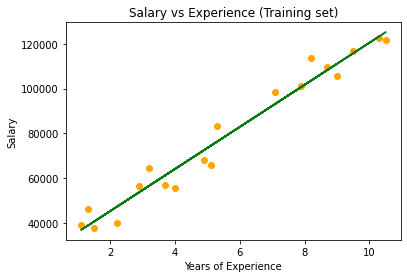

Coefficient b0:  26605.26802790384 

Coefficient b1:  9383.711536370554 

Coefficient b1 (NE):  [29196.84601015] 

Coefficient b0 (NE):  [79154.05263158] 

Coefficient b1 (SVD):  [13013.9668881] 



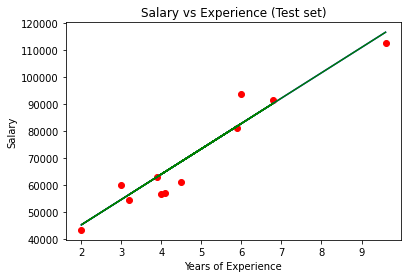

Q(b0, b1):  352731777.2785794 

Q(b0, b1):  352731777.2785795 

   x-values   y-value  y-predicted-value  y-predicted-value-cf  \
0     [3.2]   54445.0       56633.144944   [56633.14494428961]   
1     [5.9]   81363.0       81969.166092   [81969.16609249011]   
2     [3.9]   63218.0       63201.743020     [63201.743019749]   
3     [6.8]   91738.0       90414.506475    [90414.5064752236]   
4     [2.0]   43525.0       45372.691101   [45372.69110064495]   
5     [3.0]   60150.0       54756.402637  [54756.402637015504]   
6     [4.1]   57081.0       65078.485327   [65078.48532702311]   
7     [4.0]   56957.0       64140.114173   [64140.11417338606]   
8     [6.0]   93940.0       82907.537246   [82907.53724612716]   
9     [4.5]   61111.0       68831.969942   [68831.96994157133]   
10    [9.6]  112635.0      116688.898777  [116688.89877706114]   

    residual_epsilon   residual_epsilon_cf  
0        2188.144944   [2188.144944289612]  
1         606.166092    [606.166092490108]  
2       

In [102]:
from sklearn.metrics import mean_squared_error
from itertools import zip_longest

plt.scatter(x_train, y_train, color = 'orange')
plt.plot(x_train, model.predict(x_train), color = 'blue')
plt.plot(x_train, model_ne.predict(x_train), color = 'green')
plt.title('Salary vs Experience (Training set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

print('Coefficient b0: ', model.intercept_, '\n')
print('Coefficient b1: ', model.coef_[0], '\n')
print('Coefficient b1 (NE): ', model_ne.coef_, '\n')
print('Coefficient b0 (NE): ', model_ne.intercept_, '\n')
print('Coefficient b1 (SVD): ', model_svd.coef_, '\n')

plt.scatter(x_test, y_test, color = 'red')
plt.plot(x_test, y_pred, color = 'blue')
plt.plot(x_test, y_pred_ne, color = 'green')
plt.title('Salary vs Experience (Test set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

df = pd.DataFrame(list(zip_longest(x_test, y_test, y_pred, y_pred_ne, fillvalue=0)), columns=['x-values', 'y-value', 'y-predicted-value', 'y-predicted-value-cf'])
df["residual_epsilon"] = (df['y-value'] - df['y-predicted-value']).abs()
df["residual_epsilon_cf"] = (df['y-value'] - df['y-predicted-value-cf']).abs()

print('Q(b0, b1): ', mean_squared_error(y_test, y_pred) * len(x_test), '\n')
print('Q(b0, b1): ', mean_squared_error(y_test, y_pred_ne) * len(x_test), '\n')
print(df)